<a href="https://colab.research.google.com/github/naenumtou/RVModel/blob/master/PD/CHAIDSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip install optbinning -q
!pip install CHAID -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 21.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [2]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/BScore

/content/drive/My Drive/Colab Notebooks/BScore


In [3]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as md
import seaborn as sns

from CHAID import Tree, NominalColumn
from optbinning import BinningProcess, OptimalBinning
from pandas.tseries.offsets import DateOffset

# Config
pd.set_option('display.max_columns', None) #Max column width
pd.set_option('display.max_colwidth', 255) #Max length string
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning) #Off warning
warnings.simplefilter(action = 'ignore', category = FutureWarning) #Off warning
pd.options.mode.chained_assignment = None #Off warning

In [4]:
# Import data
transaction = pd.read_parquet(
    'Usedcar_transaction.parquet',
    engine = 'pyarrow'
)
print(f'Total rows: {transaction.shape[0]}\nTotal columns: {transaction.shape[1]}')

Total rows: 792456
Total columns: 31


In [5]:
# Show table
transaction.head(5)

,APPLICATION_NUMBER,BRANCH,RESTRUCTURE_FLAG,PARTIAL_PAYMENT_FLAG,OUTSTANDING_AMOUNT,CONTRACT_STATUS,TOTAL_TERM,OVERDUE_DAYS,CONTRACT_ID,CUSTOMER_NUMBER,CONTRACT_NUMBER,INSTALLMENT_AMOUNT,DUE_AMOUNT,TOTAL_PAYMENT_MADE,OVERDUE_AMOUNT,FIRST_DUE_DATE,LAST_DUE_DATE,LAST_PAID_DTE,INSTALLMENT_LAST_PAID_DTE,AS_OF_DATE,RESTRUCTURE_DATE,Br_Con,Monthblock,Product_used,Default_flag,Monthkey,FINANCED_AMT,FIRST_PAYMENT_DATE,FIRST_TRANS_MONTH,MOB,BUCKETS
0,944370,A,N,1,507120.0,10,60.0,0,944370,6626063,10000858,8452.0,8452.0,0.0,0.0,2019-05-25,2024-04-25,2019-04-23,NaT,2019-04-30,NaT,A10000858,201904,Usedcar,None,64,397714.0,2019-05-16,65.0,0.0,0
1,944370,A,N,2,498668.0,10,60.0,0,944370,6626063,10000858,8452.0,8452.0,8452.0,0.0,2019-05-25,2024-04-25,2019-05-16,2019-05-16,2019-05-31,NaT,A10000858,201904,Usedcar,None,65,397714.0,2019-05-16,65.0,1.0,0
2,944370,A,N,2,490216.0,10,60.0,0,944370,6626063,10000858,8452.0,8452.0,8452.0,0.0,2019-05-25,2024-04-25,2019-06-25,2019-06-11,2019-06-30,NaT,A10000858,201904,Usedcar,None,66,397714.0,2019-05-16,65.0,2.0,0
3,944370,A,N,2,481764.0,10,60.0,0,944370,6626063,10000858,8452.0,8452.0,8452.0,0.0,2019-05-25,2024-04-25,2019-07-19,2019-07-12,2019-07-31,NaT,A10000858,201904,Usedcar,None,67,397714.0,2019-05-16,65.0,3.0,0
4,944370,A,N,2,473312.0,10,60.0,0,944370,6626063,10000858,8452.0,8452.0,8452.0,0.0,2019-05-25,2024-04-25,2019-08-19,2019-08-19,2019-08-31,NaT,A10000858,201904,Usedcar,None,68,397714.0,2019-05-16,65.0,4.0,0


In [6]:
# Prepare dataset (Target)
# Default flag 90+ DPD (Bucket >= 4)
transaction['DEFAULT_FLAG'] = np.where(
    transaction['BUCKETS'].eq(4),
    1,
    0
)

# Using 12-Months observed default
lag = 12

for i in range(1, lag + 1):
  transaction[f'DEFAULT_FLAG{i}'] = transaction.groupby(
      ['Br_Con']
  )['DEFAULT_FLAG'].shift(-i).astype(np.float32)
  print(f'Column: {transaction.columns[-1]} created')

Column: DEFAULT_FLAG1 created
Column: DEFAULT_FLAG2 created
Column: DEFAULT_FLAG3 created
Column: DEFAULT_FLAG4 created
Column: DEFAULT_FLAG5 created
Column: DEFAULT_FLAG6 created
Column: DEFAULT_FLAG7 created
Column: DEFAULT_FLAG8 created
Column: DEFAULT_FLAG9 created
Column: DEFAULT_FLAG10 created
Column: DEFAULT_FLAG11 created
Column: DEFAULT_FLAG12 created


In [7]:
# Create ever 12-Months default status
transaction['EVER_DEFAULT'] = np.where(
    transaction.loc[:, 'DEFAULT_FLAG1':'DEFAULT_FLAG12'].max(axis = 1).eq(1),
    1,
    0
)

In [8]:
# Exclusion rules
# 1: Bad at observation point (Defaulted transaction)
# 2: Less than 12-Months forward performance window
transaction = transaction.query(
    "DEFAULT_FLAG != 1 & Monthkey <= Monthkey.max() - 12"
) #Keep original dataset before exclusion --> for testing

# 3: Last transaction (No probability to observed)
transaction = transaction[transaction['DEFAULT_FLAG1'].notnull()]

In [9]:
# Export for PD Forward-looking model
'''
The DataFrame can be exported for the PD Forward-looking model.
The summary of ODR need to be calculated based on monthly basis by portfolio.
Using the example code below as referrence.

ODR = transaction.groupby(
  ['Portfolio', 'Month'],
  as_index = False
).agg(
  N = ('EVER_DEFAULT', 'size'),
  Bad = ('EVER_DEFAULT', 'sum')
)
ODR['ODR'] = ODR['Bad'] / ODR['N']
'''

"\nThe DataFrame can be exported for the PD Forward-looking model.\nThe summary of ODR need to be calculated based on monthly basis by portfolio.\nUsing the example code below as referrence.\n\nODR = transaction.groupby(\n  ['Portfolio', 'Month'],\n  as_index = False\n).agg(\n  N = ('EVER_DEFAULT', 'size'),\n  Bad = ('EVER_DEFAULT', 'sum')\n)\nODR['ODR'] = ODR['Bad'] / ODR['N']\n"

In [10]:
# Prepare dataset (Features)
transaction['YEAR'] = transaction['FIRST_DUE_DATE'].dt.year #Open date

Features = [
    'RESTRUCTURE_FLAG',
    'TOTAL_TERM',
    'OVERDUE_DAYS',
    'INSTALLMENT_AMOUNT',
    'FINANCED_AMT',
    'MOB',
    'YEAR'
]

# Features and target seperated
X = transaction[Features]
y = transaction['EVER_DEFAULT']

In [11]:
# Binning process
binningProcess = BinningProcess(
    list(X.columns),
    n_jobs = -1
)

In [12]:
# Fitting binning
binningProcess.fit(X, y)

BinningProcess(n_jobs=-1,
               variable_names=['RESTRUCTURE_FLAG', 'TOTAL_TERM', 'OVERDUE_DAYS',
                               'INSTALLMENT_AMOUNT', 'FINANCED_AMT', 'MOB',
                               'YEAR'])

In [13]:
# Summary table
binningSummary = binningProcess.summary()
binningSummary = binningSummary.sort_values(by = ['iv'], ascending = False)
binningSummary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
2,OVERDUE_DAYS,numerical,OPTIMAL,True,5,1.644709,0.181181,0.61865,0.000686
1,TOTAL_TERM,numerical,OPTIMAL,True,3,0.25192,0.029941,0.219015,0.629632
4,FINANCED_AMT,numerical,OPTIMAL,True,9,0.097572,0.011818,0.138946,0.191529
6,YEAR,numerical,OPTIMAL,True,5,0.093974,0.011654,0.16131,0.317417
5,MOB,numerical,OPTIMAL,True,11,0.076025,0.009426,0.151052,0.220655
3,INSTALLMENT_AMOUNT,numerical,OPTIMAL,True,9,0.049498,0.006101,0.105166,0.178685
0,RESTRUCTURE_FLAG,categorical,OPTIMAL,True,1,0.0,0.0,0,0.0


In [14]:
# Single factor study
# 'OVERDUE_DAYS'
var = 'OVERDUE_DAYS'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical',
    split_digits = 0
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.00)",445303,0.752929,438262,7041,0.015812,1.105893,0.574930,0.068414
1,"[8.00, 24.00)",71316,0.120583,66006,5310,0.074457,-0.50502,0.038829,0.004803
2,"[24.00, 30.00)",33610,0.056829,30988,2622,0.078012,-0.555511,0.022671,0.002798
3,"[30.00, inf)",41199,0.069660,28788,12411,0.301245,-2.183798,0.878285,0.092129
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,1.514715,0.168144


In [15]:
# Statistical binning
transaction['OVERDUE_DAYS_A'] = optb.transform(XVar, metric = 'bins')

# Re-binning
def Group(ovd):
  if ovd == 0:      return '0'
  elif ovd <= 30:   return '1-30'
  elif ovd > 30:    return '30+'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['OVERDUE_DAYS'])
transaction['OVERDUE_DAYS_M'] = bins

In [16]:
# 'TOTAL_TERM'
var = 'TOTAL_TERM'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical',
    split_digits = 0
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 57.00)",103785,0.175482,102473,1312,0.012642,1.332873,0.178291,0.020771
1,"[57.00, 61.00)",158556,0.268090,152779,5777,0.036435,0.249935,0.014971,0.001867
2,"[61.00, inf)",329087,0.556428,308792,20295,0.061671,-0.30288,0.058657,0.007304
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,0.251920,0.029941


In [17]:
# Statistical binning
transaction['TOTAL_TERM_A'] = optb.transform(XVar, metric = 'bins')

# Re-binning
def Group(term):
  if term <= 60:      return 'Tenor<=60'
  elif term > 60:     return 'Tenor>60'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['TOTAL_TERM'])
transaction['TOTAL_TERM_M'] = bins

In [18]:
# 'FINANCED_AMT'
var = 'FINANCED_AMT'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical',
    split_digits = 0
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 262325.00)",34271,0.057946,33768,503,0.014677,1.181505,0.049032,0.005796
1,"[262325.00, 310648.00)",44543,0.075314,43369,1174,0.026357,0.584155,0.019872,0.002449
2,"[310648.00, 332218.00)",34158,0.057755,32992,1166,0.034135,0.317513,0.005052,0.000629
3,"[332218.00, 353750.00)",34446,0.058242,33167,1279,0.037131,0.230304,0.002786,0.000347
4,"[353750.00, 380885.00)",48303,0.081672,46226,2077,0.042999,0.077445,0.000473,0.000059
5,"[380885.00, 428002.00)",89739,0.151733,85275,4464,0.049744,-0.075337,0.000891,0.000111
6,"[428002.00, 516989.00)",124734,0.210903,118110,6624,0.053105,-0.144256,0.004688,0.000585
7,"[516989.00, 777172.00)",148752,0.251513,140757,7995,0.053747,-0.156955,0.006656,0.000831
8,"[777172.00, inf)",32482,0.054921,30380,2102,0.064713,-0.354278,0.008113,0.001009
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [19]:
# Statistical binning
transaction['FINANCED_AMT_A'] = optb.transform(XVar, metric = 'bins')

# Re-binning --> (Further study: Reduce bins to maximum as 3 bins)
def Group(fin):
  if fin <= 262000.00:      return 'FIN_AMT<=262000'
  elif fin <= 353000.00:    return 'FIN_AMT<=353000'
  elif fin > 353000.00:     return 'FIN_AMT>353000'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['FINANCED_AMT'])
transaction['FINANCED_AMT_M'] = bins

In [20]:
# 'YEAR'
var = 'YEAR'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical',
    split_digits = 0
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2016.00)",386011,0.652676,366729,19282,0.049952,-0.079722,0.004301,0.000538
1,"[2016.00, 2018.00)",160679,0.271680,155710,4969,0.030925,0.419603,0.039696,0.004926
2,"[2018.00, inf)",44738,0.075644,41605,3133,0.070030,-0.438944,0.017842,0.002213
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,0.061840,0.007676


In [21]:
# 'YEAR' --> (Further study: Try categorical variable)
var = 'YEAR'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'categorical'
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[2016],76705,0.129695,74702,2003,0.026113,0.593687,0.035203,0.004337
1,[2017],83974,0.141985,81008,2966,0.035320,0.28216,0.009963,0.001241
2,[2015],121162,0.204863,116727,4435,0.036604,0.245137,0.011029,0.001375
3,[2014],264849,0.447813,250002,14847,0.056058,-0.201502,0.019938,0.002488
4,"[2018, 2019]",44738,0.075644,41605,3133,0.070030,-0.438944,0.017842,0.002213
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,0.093974,0.011654


In [22]:
# Statistical binning
transaction['YEAR_A'] = optb.transform(XVar, metric = 'bins')

# Re-binning
def Group(year):
  if year <= 2015:      return 'Pre-2015'
  elif year > 2015:     return 'Post-2015'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['YEAR'])
transaction['YEAR_M'] = bins

In [23]:
# 'MOB'
var = 'MOB'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical'
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.50)",128503,0.217276,120627,7876,0.061290,-0.29629,0.021852,0.002722
1,"[5.50, 7.50)",37425,0.063279,35250,2175,0.058116,-0.239736,0.004059,0.000506
2,"[7.50, 10.50)",52587,0.088915,49818,2769,0.052656,-0.135283,0.001731,0.000216
3,"[10.50, 12.50)",32686,0.055266,31039,1647,0.050389,-0.088884,0.000455,0.000057
4,"[12.50, 16.50)",59327,0.100311,56499,2828,0.047668,-0.03052,0.000095,0.000012
5,"[16.50, 21.50)",61644,0.104229,58857,2787,0.045211,0.024972,0.000064,0.000008
6,"[21.50, 26.50)",51229,0.086619,49120,2109,0.041168,0.122879,0.001237,0.000155
7,"[26.50, 30.50)",35804,0.060538,34471,1333,0.037230,0.227513,0.002829,0.000353
8,"[30.50, 37.50)",51926,0.087798,50236,1690,0.032546,0.36683,0.010032,0.001247
9,"[37.50, 43.50)",34997,0.059174,33975,1022,0.029203,0.47869,0.010969,0.001358


In [24]:
# 'MOB' --> (Further study: Reduce bins to maximum as 2 bins)
var = 'MOB'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'numerical',
    max_n_bins = 2
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 21.50)",372172,0.629277,352090,20082,0.053959,-0.16111,0.017581,0.002195
1,"[21.50, inf)",219256,0.370723,211954,7302,0.033304,0.343048,0.037435,0.004657
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,0.055016,0.006852


In [25]:
# 'MOB' --> (Further study: Try categorical variable)
var = 'MOB'
XVar = transaction[var]
optb = OptimalBinning(
    name = var,
    dtype = 'categorical',
    max_n_bins = 2
)
optb.fit(XVar, y)

# Opt result
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[62.0, 61.0, 57.0, 58.0, 54.0, 55.0, 56.0, 59.0, 53.0, 45.0, 52.0, 46.0, 60.0, 44.0, 51.0, 49.0, 47.0, 50.0, 48.0, 41.0, 43.0, 39.0, 42.0, 40.0, 38.0, 37.0, 35.0, 36.0, 33.0, 32.0, 34.0, 31.0, 30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, -1.0]",224504,0.379597,216976,7528,0.033532,0.335984,0.036882,0.004589
1,"[21.0, 17.0, 19.0, 18.0, 20.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 9.0, 10.0, 8.0, 0.0, 7.0, 1.0, 6.0, 5.0, 2.0, 4.0, 3.0]",366924,0.620403,347068,19856,0.054115,-0.164159,0.018020,0.002250
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,591428,1.000000,564044,27384,0.046301,,0.054903,0.006839


In [26]:
# Re-binning --> (Manual cut-off as 6 and 12)
def Group(mob):
  if mob <= 6:      return 'MOB<=6'
  elif mob > 6:     return 'MOB>6'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['MOB'])
transaction['MOB_6'] = bins

# Re-binning --> (Manual cut-off as 6 and 12)
def Group(mob):
  if mob <= 12:      return 'MOB<=12'
  elif mob > 12:     return 'MOB>12'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(Group)
bins = func(transaction['MOB'])
transaction['MOB_12'] = bins

In [27]:
# New features and target seperated
Features = [
    'OVERDUE_DAYS_A',
    'OVERDUE_DAYS_M',
    'TOTAL_TERM_A',
    'TOTAL_TERM_M',
    'FINANCED_AMT_A',
    'FINANCED_AMT_M',
    'YEAR_A',
    'YEAR_M',
    'MOB_6',
    'MOB_12'
]

X = transaction[Features]

# Binning process
binningProcess = BinningProcess(
    list(X.columns),
    n_jobs = -1
)

# Fitting binning
binningProcess.fit(X, y)

BinningProcess(n_jobs=-1,
               variable_names=['OVERDUE_DAYS_A', 'OVERDUE_DAYS_M',
                               'TOTAL_TERM_A', 'TOTAL_TERM_M', 'FINANCED_AMT_A',
                               'FINANCED_AMT_M', 'YEAR_A', 'YEAR_M', 'MOB_6',
                               'MOB_12'])

In [28]:
# Summary table
binningSummary = binningProcess.summary()
binningSummary = binningSummary.sort_values(by = ['iv'], ascending = False)
binningSummary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
1,OVERDUE_DAYS_M,categorical,OPTIMAL,True,3,1.636813,0.180236,0.612017,0.000739
0,OVERDUE_DAYS_A,categorical,OPTIMAL,True,4,1.514715,0.168144,0.583583,0.001962
2,TOTAL_TERM_A,categorical,OPTIMAL,True,3,0.25192,0.029941,0.219015,0.629632
3,TOTAL_TERM_M,categorical,OPTIMAL,True,2,0.166826,0.020652,0.193665,0.418557
4,FINANCED_AMT_A,categorical,OPTIMAL,True,9,0.097562,0.011817,0.138942,0.191749
6,YEAR_A,categorical,OPTIMAL,True,5,0.093974,0.011654,0.16131,0.27763
5,FINANCED_AMT_M,categorical,OPTIMAL,True,3,0.082927,0.010025,0.10433,0.164451
9,MOB_12,categorical,OPTIMAL,True,2,0.047487,0.005924,0.108593,0.127981
8,MOB_6,categorical,OPTIMAL,True,2,0.033827,0.004217,0.082976,0.070085
7,YEAR_M,categorical,OPTIMAL,True,2,0.01334,0.001666,0.053956,0.033578


In [29]:
# Define summary function
def BinningSummary(BinningObject):
  summary = []
  for factor in BinningObject.get_support(names = True):
    build = binningProcess.get_binned_variable(factor)
    df = build.binning_table.build()
    df['Factor'] = factor
    df = df.drop(df.tail(1).index) #Drop total row
    summary.append(df)
  summary = pd.concat(summary, axis = 0)
  cols = summary.columns
  cols = cols[-1:].append(cols[:-1])
  summary = summary[cols]
  return summary

In [30]:
# Show binning summary
BinningSummary(binningProcess)

,Factor,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,OVERDUE_DAYS_A,"[(-inf, 8.00)]",445303,0.752929,438262,7041,0.015812,1.105893,0.574930,0.068414
1,OVERDUE_DAYS_A,"[[8.00, 24.00)]",71316,0.120583,66006,5310,0.074457,-0.50502,0.038829,0.004803
2,OVERDUE_DAYS_A,"[[24.00, 30.00)]",33610,0.056829,30988,2622,0.078012,-0.555511,0.022671,0.002798
3,OVERDUE_DAYS_A,"[[30.00, inf)]",41199,0.069660,28788,12411,0.301245,-2.183798,0.878285,0.092129
4,OVERDUE_DAYS_A,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,OVERDUE_DAYS_A,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
0,OVERDUE_DAYS_M,[0],414247,0.700418,408873,5374,0.012973,1.306659,0.690765,0.080684
1,OVERDUE_DAYS_M,[1-30],139262,0.235467,129230,10032,0.072037,-0.46936,0.064411,0.007978
2,OVERDUE_DAYS_M,[30+],37919,0.064114,25941,11978,0.315884,-2.25242,0.881637,0.091574
3,OVERDUE_DAYS_M,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [31]:
# Final columns
cols = [
    'OVERDUE_DAYS_M',
    'TOTAL_TERM_M',
    'FINANCED_AMT_M',
    'MOB_12',
    'EVER_DEFAULT'
]

# Data selection
train = transaction[cols]

In [32]:
# CHAID Segmentation
tree = Tree.from_pandas_df(
    train,
    {
        'OVERDUE_DAYS_M': 'nominal',
        'TOTAL_TERM_M': 'nominal',
        'FINANCED_AMT_M': 'nominal',
        'MOB_12': 'nominal'
    },
    'EVER_DEFAULT',
    max_depth = len(cols) - 1
)

In [33]:
# Print CHAID Tree result
tree.print_tree()

([], {np.int64(0): np.float64(564044.0), np.int64(1): np.float64(27384.0)}, (OVERDUE_DAYS_M, p=0.0, score=74916.262615193, groups=[['0'], ['1-30'], ['30+']]), dof=2))
|-- (['0'], {np.int64(0): np.float64(408873.0), np.int64(1): np.float64(5374.0)}, (MOB_12, p=0.0, score=2196.625284681906, groups=[['MOB<=12'], ['MOB>12']]), dof=1))
|   |-- (['MOB<=12'], {np.int64(0): np.float64(195529.0), np.int64(1): np.float64(4298.0)}, (TOTAL_TERM_M, p=2.0362970993519726e-247, score=1128.5727099454737, groups=[['Tenor<=60'], ['Tenor>60']]), dof=1))
|   |   |-- (['Tenor<=60'], {np.int64(0): np.float64(97406.0), np.int64(1): np.float64(1028.0)}, (FINANCED_AMT_M, p=1.7065317683745947e-23, score=104.84998806714347, groups=[['FIN_AMT<=262000'], ['FIN_AMT<=353000'], ['FIN_AMT>353000']]), dof=2))
|   |   |   |-- (['FIN_AMT<=262000'], {np.int64(0): np.float64(12062.0), np.int64(1): np.float64(51.0)}, <Invalid Chaid Split> - the max depth has been reached)
|   |   |   |-- (['FIN_AMT<=353000'], {np.int64(0): n

In [34]:
# Assign segment to data
def SegmentAssign(ovd, mob, tenor, fin):
  if ovd == 0 and mob <= 12 and tenor <= 60 and fin <= 262000:                return 'Segment_0'
  elif ovd == 0 and mob <= 12 and tenor <= 60 and fin <= 353000:              return 'Segment_1'
  elif ovd == 0 and mob <= 12 and tenor <= 60 and fin > 353000:               return 'Segment_2'
  elif ovd == 0 and mob <= 12 and tenor > 60 and fin <= 262000:               return 'Segment_3'
  elif ovd == 0 and mob <= 12 and tenor > 60 and fin <= 353000:               return 'Segment_4'
  elif ovd == 0 and mob <= 12 and tenor > 60 and fin > 353000:                return 'Segment_5'
  elif ovd == 0 and mob > 12 and tenor <= 60 and fin <= 262000:               return 'Segment_6'
  elif ovd == 0 and mob > 12 and tenor <= 60 and fin > 262000:                return 'Segment_7'
  elif ovd == 0 and mob > 12 and tenor > 60 and fin <= 353000:                return 'Segment_8'
  elif ovd == 0 and mob > 12 and tenor > 60 and fin > 353000:                 return 'Segment_9'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor <= 60 and fin <= 353000:      return 'Segment_10'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor <= 60 and fin > 353000:       return 'Segment_11'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor > 60 and fin <= 262000:       return 'Segment_12'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor > 60 and fin <= 353000:       return 'Segment_13'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor > 60 and fin > 353000:        return 'Segment_14'
  elif (1 <= ovd <= 30) and mob > 12 and tenor <= 60 and fin <= 262000:       return 'Segment_15'
  elif (1 <= ovd <= 30) and mob > 12 and tenor <= 60 and fin > 262000:        return 'Segment_16'
  elif (1 <= ovd <= 30) and mob > 12 and tenor > 60 and fin <= 353000:        return 'Segment_17'
  elif (1 <= ovd <= 30) and mob > 12 and tenor > 60 and fin > 353000:         return 'Segment_18'
  elif ovd > 30 and mob <= 12 and fin <= 353000 and tenor <= 60:              return 'Segment_19'
  elif ovd > 30 and mob <= 12 and fin <= 353000 and tenor > 60:               return 'Segment_20'
  elif ovd > 30 and mob <= 12 and fin > 353000:                               return 'Segment_21'
  elif ovd > 30 and mob > 12 and tenor <= 60:                                 return 'Segment_22'
  elif ovd > 30 and mob > 12 and tenor > 60 and fin <= 262000:                return 'Segment_23'
  elif ovd > 30 and mob > 12 and tenor > 60 and fin > 262000:                 return 'Segment_24'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(SegmentAssign)
segment = func(transaction['OVERDUE_DAYS'], transaction['MOB'], transaction['TOTAL_TERM'], transaction['FINANCED_AMT'])
transaction['SEGMENT_OPTION1'] = segment

In [35]:
# Define function model classification ability
def ClassificationTest(df):
  table = df.copy()
  table = table.sort_values(
      by = ['ODR'],
      ascending = False
  )
  table['Good'] = table['N'] - table['Bad']
  table['cumBad'] = table['Bad'].cumsum() / table['Bad'].sum()
  table['cumGood'] = table['Good'].cumsum() / table['Good'].sum()
  table['ROC'] = (table['cumGood'] - table['cumGood'].shift(1, fill_value = 0)) * \
                 (table['cumBad'] + table['cumBad'].shift(1, fill_value = 0)) * 0.5
  table['KS'] = abs(table['cumGood'] - table['cumBad'])
  return table

In [36]:
# Define function for summary and classification testing
def SummaryOption(df, option):
  table = df.groupby(
      [option],
      as_index = False
  ).agg(
      N = ('EVER_DEFAULT', 'size'),
      Bad = ('EVER_DEFAULT', 'sum')
  ).eval(
      """
      ODR = Bad / N
      N_pct = N / N.sum()
      """
  )
  return ClassificationTest(table)

In [37]:
# Define function for summary and classification back-testing
def BacktestOption(df, option, output = True):
  summary = SummaryOption(df, option) #Call for the plot
  table = df.groupby(
      ['AS_OF_DATE', option],
      as_index = False
  ).agg(
      N = ('EVER_DEFAULT', 'size'),
      Bad = ('EVER_DEFAULT', 'sum')
  ).eval(
      """
      ODR = Bad / N
      """
  )
  if output is True:
    return table
  else:
    auc = []
    gini = []
    ks = []
    for month in table['AS_OF_DATE'].unique():
      table1 = ClassificationTest(table.query("AS_OF_DATE == @month"))
      auc.append(float(table1['ROC'].sum()))
      gini.append(float(table1['ROC'].sum() * 2 - 1))
      ks.append(float(table1['KS'].max()))
  # Plot
  fig, axs = plt.subplots(1, 3, figsize = (21, 4), sharex = True)
  fig.subplots_adjust(wspace = 0.2)
  axs = axs.ravel()
  axs[0].set_title(f'AUC: {option}')
  axs[0].plot(table['AS_OF_DATE'].unique(), auc, c = 'royalblue', linewidth = 2)
  axs[0].plot([], [], ' ', label = f"AUC: {summary['ROC'].sum() * 100:.2f}%")
  axs[0].margins(0) #Remove default margins
  axs[0].axhspan(0, 0.6, facecolor = '#C00000', alpha = 0.5)
  axs[0].axhspan(0.6, 0.7, facecolor = '#FFC000', alpha = 0.5)
  axs[0].axhspan(0.7, 1.0, facecolor = '#00B050', alpha = 0.5)
  axs[0].legend(frameon = True, facecolor = 'white')
  axs[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100)))
  axs[1].set_title(f'GINI: {option}')
  axs[1].plot(table['AS_OF_DATE'].unique(), gini, c = 'royalblue', linewidth = 2)
  axs[1].plot([], [], ' ', label = f"GINI: {(summary['ROC'].sum() * 2 - 1) * 100:.2f}%")
  axs[1].margins(0) #Remove default margins
  axs[1].axhspan(0, 0.2, facecolor = '#C00000', alpha = 0.5)
  axs[1].axhspan(0.2, 0.4, facecolor = '#FFC000', alpha = 0.5)
  axs[1].axhspan(0.4, 1.0, facecolor = '#00B050', alpha = 0.5)
  axs[1].legend(frameon = True, facecolor = 'white')
  axs[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100)))
  axs[2].set_title(f'KS: {option}')
  axs[2].plot(table['AS_OF_DATE'].unique(), ks, c = 'royalblue', linewidth = 2)
  axs[2].plot([], [], ' ', label = f"KS: {summary['KS'].max() * 100:.2f}%")
  axs[2].margins(0) #Remove default margins
  axs[2].axhspan(0, 0.2, facecolor = '#C00000', alpha = 0.5)
  axs[2].axhspan(0.2, 0.4, facecolor = '#FFC000', alpha = 0.5)
  axs[2].axhspan(0.4, 1.0, facecolor = '#00B050', alpha = 0.5)
  axs[2].legend(frameon = True, facecolor = 'white')
  axs[2].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100)))
  return plt.show()

In [38]:
# Define function for stable back-testing
def StableOption(df, option):
  # PSI
  table = BacktestOption(df, option)
  psi = []
  for month in table['AS_OF_DATE'].unique():
    if month == table['AS_OF_DATE'].max():
      pass
    else:
      table1 = table.query("AS_OF_DATE == @month")
      month2 = month + DateOffset(months = 1)
      table2 = table.query("AS_OF_DATE == @month2")
      temp = pd.merge(
          table1,
          table2,
          how = 'left',
          left_on = [option],
          right_on = [option]
      )
      data1 = temp['N_x'] / temp['N_x'].sum()
      data2 = temp['N_y'] / temp['N_y'].sum()
      psi.append(float(np.sum((data1 - data2) * np.log(data1 / data2))))
  # Proportion analysis
  # Create equal proportion table
  protion = []
  for i in table[option].unique():
    temp = pd.DataFrame(
        pd.date_range(start = table['AS_OF_DATE'].min(), end = table['AS_OF_DATE'].max(), freq = 'M'),
        columns = ['AS_OF_DATE']
    )
    temp[option] = i
    protion.append(temp)
  protion = pd.concat(protion, axis = 0)
  protion = pd.merge(
      protion,
      table[['AS_OF_DATE', option, 'N']],
      how = 'left',
      left_on = ['AS_OF_DATE', option],
      right_on = ['AS_OF_DATE', option],
  ).fillna(0).sort_values(
      by = ['AS_OF_DATE', option],
      ignore_index = True
  )
  SegmentAll = []
  for i in protion[option].unique():
    segment1 = np.array(protion[protion[option] == i]['N'])
    SegmentAll.append(segment1)
  SegmentAll = np.array(SegmentAll)
  # Plot
  fig, axs = plt.subplots(1, 2, figsize = (14, 4), sharex = True)
  fig.subplots_adjust(wspace = 0.2)
  axs = axs.ravel()
  axs[0].set_title(f'Month-on-Month PSI: {option}')
  axs[0].plot(table['AS_OF_DATE'].unique()[:-1], psi, c = 'royalblue', linewidth = 2) #Drop last index
  axs[0].plot([], [], ' ', label = f"PSI: {np.mean(psi) * 100:.2f}%")
  axs[0].margins(0) #Remove default margins
  axs[0].axhspan(0, 0.1, facecolor = '#00B050', alpha = 0.5)
  axs[0].axhspan(0.1, 0.25, facecolor = '#FFC000', alpha = 0.5)
  axs[0].axhspan(0.25, 1.0, facecolor = '#C00000', alpha = 0.5)
  axs[0].legend(frameon = True, facecolor = 'white')
  axs[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100)))
  axs[1].set_title(f'Proportion analysis: {option}')
  col = sns.color_palette('vlag', protion[option].nunique())
  axs[1].stackplot(
      table['AS_OF_DATE'].unique(),
      SegmentAll / SegmentAll.sum(axis = 0).astype(float) * 100,
      colors = col,
      labels = protion[option].unique()
  )
  axs[1].margins(0) #Remove default margins
  axs[1].legend(bbox_to_anchor=(1, 1), loc = 'upper left')
  axs[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x)))
  return plt.show()

In [39]:
# Option 1: Summary
SummaryOption(transaction, 'SEGMENT_OPTION1')

,SEGMENT_OPTION1,N,Bad,ODR,N_pct,Good,cumBad,cumGood,ROC,KS
14,Segment_21,9406,4416,0.469488,0.015904,4990,0.161262,0.008847,0.000713,0.152415
13,Segment_20,762,306,0.401575,0.001288,456,0.172436,0.009655,0.000135,0.162781
11,Segment_19,747,252,0.337349,0.001263,495,0.181639,0.010533,0.000155,0.171106
17,Segment_24,19022,5129,0.269635,0.032163,13893,0.368938,0.035164,0.006781,0.333774
15,Segment_22,7824,1851,0.236580,0.013229,5973,0.436532,0.045754,0.004265,0.390779
16,Segment_23,158,24,0.151899,0.000267,134,0.437409,0.045991,0.000104,0.391418
6,Segment_14,23532,3499,0.148691,0.039788,20033,0.565184,0.081508,0.017804,0.483676
3,Segment_11,9763,1069,0.109495,0.016508,8694,0.604221,0.096922,0.009012,0.507300
5,Segment_13,3164,344,0.108723,0.005350,2820,0.616784,0.101921,0.003052,0.514862
2,Segment_10,3749,268,0.071486,0.006339,3481,0.626570,0.108093,0.003837,0.518478


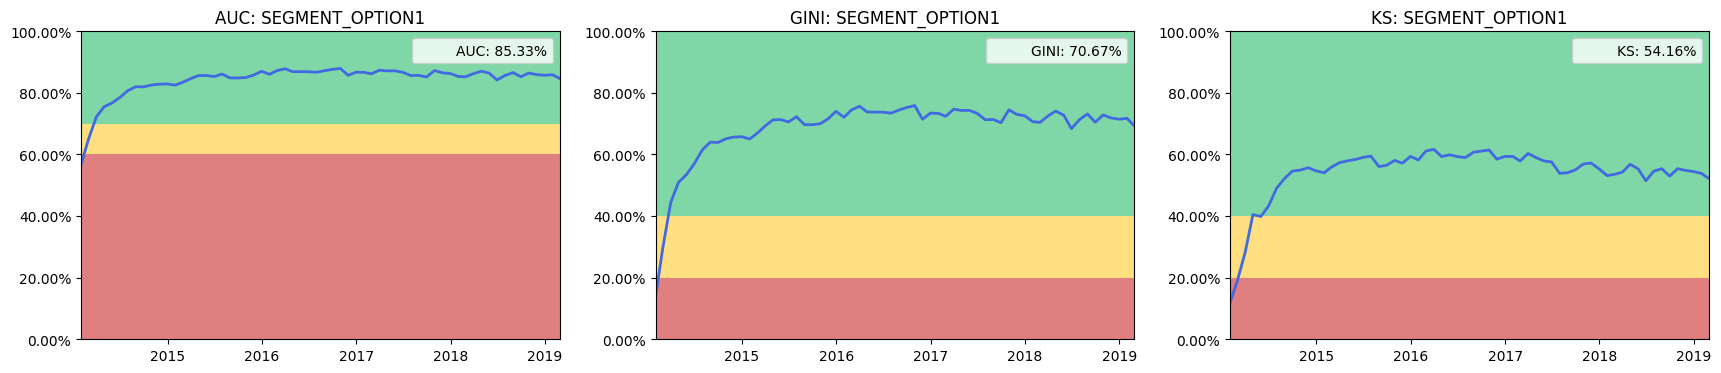

In [40]:
# Option 1: Back-testing
BacktestOption(transaction, 'SEGMENT_OPTION1', output = False)

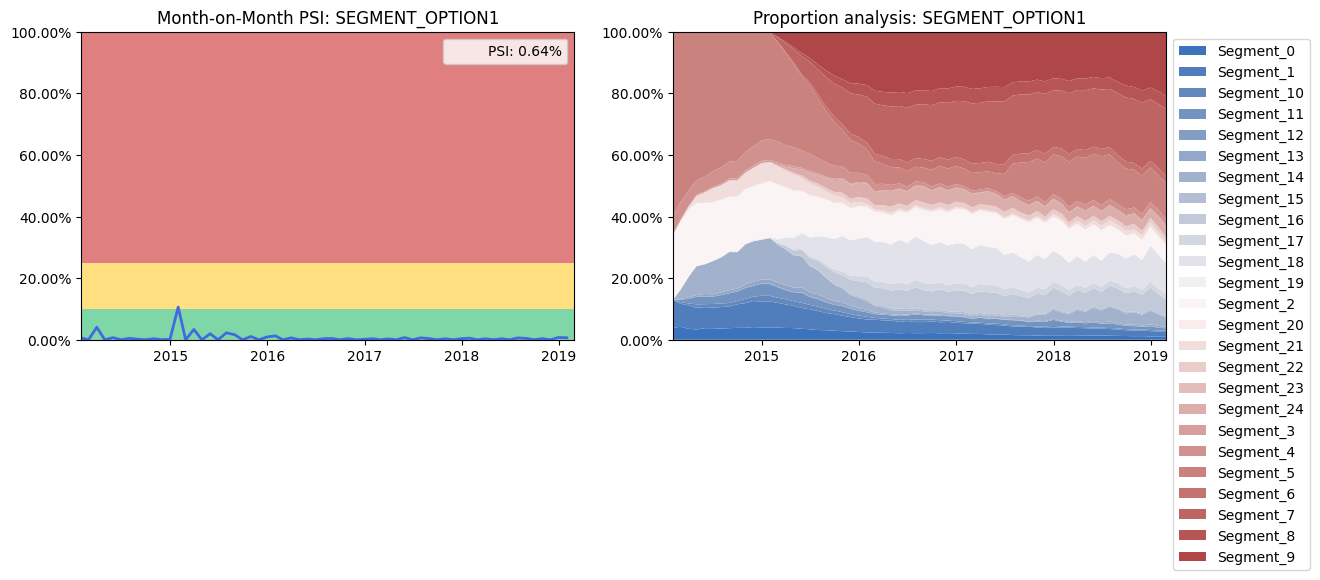

In [41]:
# Option 1: Stable analysis
StableOption(transaction, 'SEGMENT_OPTION1')

In [42]:
# Define function for ODR Analysis
def ODRAnalysis(df, option, SegmentList):
  odr = BacktestOption(df, option)
  # Plot
  fig, axs = plt.subplots(1, len(SegmentList), figsize = (24, 4), sharex = True)
  for ax, lst in zip(axs.flat, SegmentList):
    fig.suptitle(f'ODR Analysis: {option}')
    temp = odr[odr[option].isin(lst)]
    sns.lineplot(
        x = 'AS_OF_DATE',
        y = 'ODR',
        data = temp,
        hue = option,
        legend = 'full',
        ax = ax
    )
    ax.set_ylabel('')
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100)))
  return plt.show()

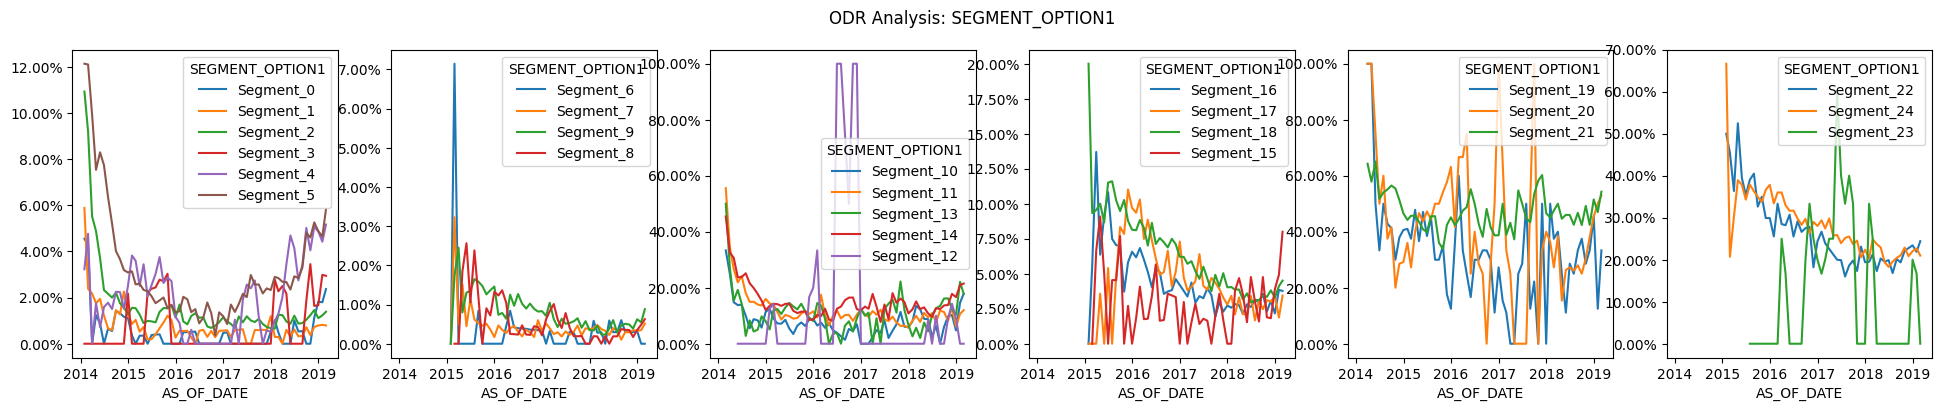

In [43]:
# ODR Analysis
SegmentList = [
    ['Segment_0','Segment_1','Segment_2','Segment_3','Segment_4','Segment_5'],
    ['Segment_6','Segment_7','Segment_8','Segment_9'],
    ['Segment_10','Segment_11','Segment_12','Segment_13','Segment_14'],
    ['Segment_15','Segment_16','Segment_17','Segment_18'],
    ['Segment_19','Segment_20','Segment_21'],
    ['Segment_22','Segment_23','Segment_24']
]

# Plot
ODRAnalysis(transaction, 'SEGMENT_OPTION1', SegmentList)

In [44]:
# Re-segment --> Option 2: Using minimum sample (5%)
tree = Tree.from_pandas_df(
    train,
    {
        'OVERDUE_DAYS_M': 'nominal',
        'TOTAL_TERM_M': 'nominal',
        'FINANCED_AMT_M': 'nominal',
        'MOB_12': 'nominal'
    },
    'EVER_DEFAULT',
    max_depth = len(cols) - 1,
    min_child_node_size = 0.05
)

# Print CHAID Tree result
tree.print_tree()

([], {np.int64(0): np.float64(564044.0), np.int64(1): np.float64(27384.0)}, (OVERDUE_DAYS_M, p=0.0, score=74916.262615193, groups=[['0'], ['1-30'], ['30+']]), dof=2))
|-- (['0'], {np.int64(0): np.float64(408873.0), np.int64(1): np.float64(5374.0)}, (MOB_12, p=0.0, score=2196.625284681906, groups=[['MOB<=12'], ['MOB>12']]), dof=1))
|   |-- (['MOB<=12'], {np.int64(0): np.float64(195529.0), np.int64(1): np.float64(4298.0)}, (TOTAL_TERM_M, p=2.0362970993519726e-247, score=1128.5727099454737, groups=[['Tenor<=60'], ['Tenor>60']]), dof=1))
|   |   |-- (['Tenor<=60'], {np.int64(0): np.float64(97406.0), np.int64(1): np.float64(1028.0)}, (FINANCED_AMT_M, p=2.4502958726413316e-23, score=99.05948939116786, groups=[['FIN_AMT<=262000', 'FIN_AMT<=353000'], ['FIN_AMT>353000']]), dof=1))
|   |   |   |-- (['FIN_AMT<=262000', 'FIN_AMT<=353000'], {np.int64(0): np.float64(33676.0), np.int64(1): np.float64(203.0)}, <Invalid Chaid Split> - the max depth has been reached)
|   |   |   +-- (['FIN_AMT>353000'],

In [45]:
# Assign segment to data
def SegmentAssign(ovd, mob, tenor, fin):
  if ovd == 0 and mob <= 12 and tenor <= 60 and fin <= 353000:       return 'Segment_0'
  elif ovd == 0 and mob <= 12 and tenor <= 60 and fin > 353000:      return 'Segment_1'
  elif ovd == 0 and mob <= 12 and tenor > 60:                        return 'Segment_2'
  elif ovd == 0 and mob > 12 and tenor <= 60:                        return 'Segment_3'
  elif ovd == 0 and mob > 12 and tenor > 60:                         return 'Segment_4'
  elif (1 <= ovd <= 30) and mob <= 12:                               return 'Segment_5'
  elif (1 <= ovd <= 30) and mob > 12 and tenor <= 60:                return 'Segment_6'
  elif (1 <= ovd <= 30) and mob > 12 and tenor > 60:                 return 'Segment_7'
  elif ovd > 30:                                                     return 'Segment_8'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(SegmentAssign)
segment = func(transaction['OVERDUE_DAYS'], transaction['MOB'], transaction['TOTAL_TERM'], transaction['FINANCED_AMT'])
transaction['SEGMENT_OPTION2'] = segment

In [46]:
# Option 2: Summary
SummaryOption(transaction, 'SEGMENT_OPTION2')

,SEGMENT_OPTION2,N,Bad,ODR,N_pct,Good,cumBad,cumGood,ROC,KS
8,Segment_8,37919,11978,0.315884,0.064114,25941,0.437409,0.045991,0.010058,0.391418
5,Segment_5,40459,5195,0.128402,0.068409,35264,0.627118,0.108511,0.033277,0.518607
7,Segment_7,65684,3629,0.055249,0.111060,62055,0.759641,0.218529,0.076284,0.541112
6,Segment_6,33119,1208,0.036475,0.055998,31911,0.803754,0.275104,0.044225,0.528650
2,Segment_2,101393,3270,0.032251,0.171438,98123,0.923167,0.449068,0.150210,0.474099
1,Segment_1,64555,825,0.012780,0.109151,63730,0.953294,0.562055,0.106008,0.391238
4,Segment_4,107948,714,0.006614,0.182521,107234,0.979368,0.752172,0.183715,0.227196
0,Segment_0,33879,203,0.005992,0.057283,33676,0.986781,0.811876,0.058694,0.174904
3,Segment_3,106472,362,0.003400,0.180025,106110,1.000000,1.000000,0.186880,0.000000


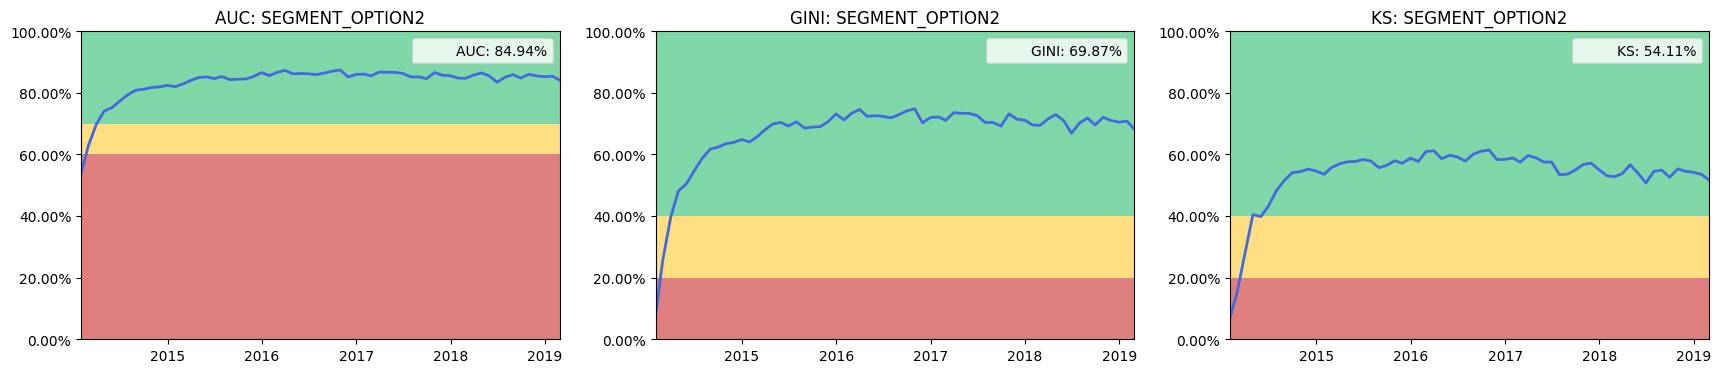

In [47]:
# Option 2: Back-testing
BacktestOption(transaction, 'SEGMENT_OPTION2', output = False)

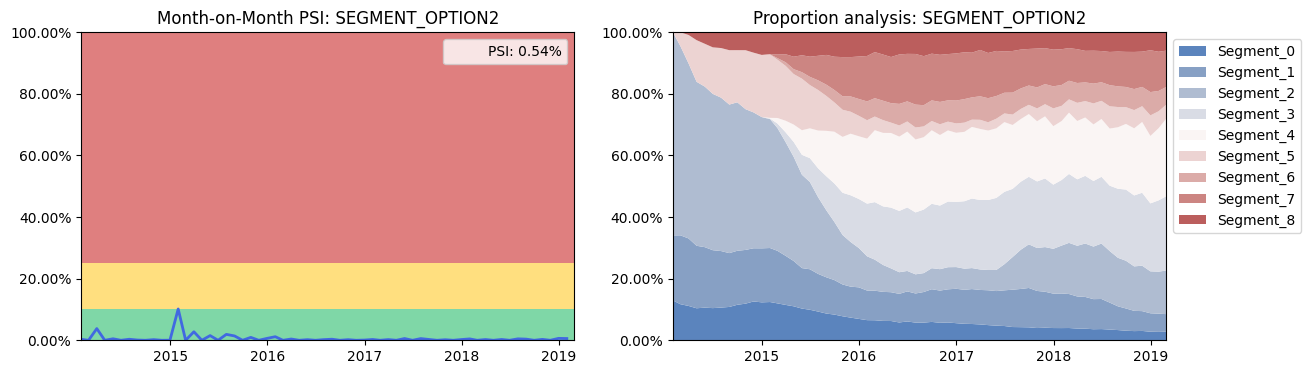

In [48]:
# Option 2: Stable analysis
StableOption(transaction, 'SEGMENT_OPTION2')

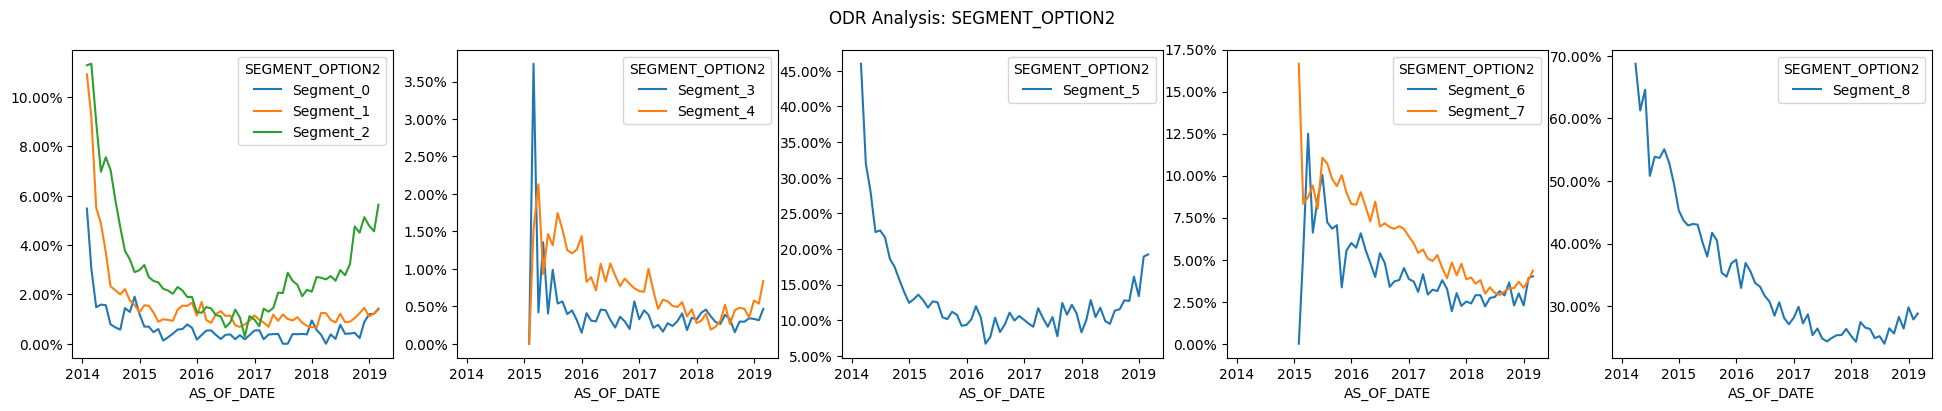

In [49]:
# ODR Analysis
SegmentList = [
    ['Segment_0','Segment_1','Segment_2'],
    ['Segment_3', 'Segment_4'],
    ['Segment_5'],
    ['Segment_6','Segment_7'],
    ['Segment_8']
]

# Plot
ODRAnalysis(transaction, 'SEGMENT_OPTION2', SegmentList)

In [50]:
# Re-segment --> Option 3: Manual collapse segments (Result from option 1)
'''
Collaps segment 0, 1, 2:  Having low number of observation
Collaps segment 3, 4, 5:  Having low number of observation
Collaps segment 6, 7:  Having low number of observation
Collaps segment 8, 9:  Having low number of observation
Collaps segment 10, 11:  Having low number of observation
Collaps segment 12, 13, 14:  Having low number of observation
Collaps segment 15, 16:  Having low number of observation
Collaps segment 17, 18:  Having low number of observation
Collaps segment 19, 20:  Having low number of observation
Collaps segment 22, 23, 24: Segment 22 and 24 have similar trend and Segment 23 has low number of observation
'''

def SegmentAssign(ovd, mob, tenor, fin):
  if ovd == 0 and mob <= 12 and tenor <= 60:                return 'Segment_0'
  elif ovd == 0 and mob <= 12 and tenor > 60:               return 'Segment_1'
  elif ovd == 0 and mob > 12 and tenor <= 60:               return 'Segment_2'
  elif ovd == 0 and mob > 12 and tenor > 60:                return 'Segment_3'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor <= 60:      return 'Segment_4'
  elif (1 <= ovd <= 30) and mob <= 12 and tenor > 60:       return 'Segment_5'
  elif (1 <= ovd <= 30) and mob > 12 and tenor <= 60:       return 'Segment_6'
  elif (1 <= ovd <= 30) and mob > 12 and tenor > 60:        return 'Segment_7'
  elif ovd > 30 and mob <= 12 and fin <= 353000:            return 'Segment_8'
  elif ovd > 30 and mob <= 12 and fin > 353000:             return 'Segment_9'
  elif ovd > 30 and mob > 12:                               return 'Segment_10'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(SegmentAssign)
segment = func(transaction['OVERDUE_DAYS'], transaction['MOB'], transaction['TOTAL_TERM'], transaction['FINANCED_AMT'])
transaction['SEGMENT_OPTION3'] = segment

In [51]:
# Option 3: Summary
SummaryOption(transaction, 'SEGMENT_OPTION3')

,SEGMENT_OPTION3,N,Bad,ODR,N_pct,Good,cumBad,cumGood,ROC,KS
10,Segment_9,9406,4416,0.469488,0.015904,4990,0.161262,0.008847,0.000713,0.152415
9,Segment_8,1509,558,0.369781,0.002551,951,0.181639,0.010533,0.000289,0.171106
2,Segment_10,27004,7004,0.259369,0.045659,20000,0.437409,0.045991,0.010975,0.391418
6,Segment_5,26947,3858,0.143170,0.045563,23089,0.578294,0.086926,0.020789,0.491368
5,Segment_4,13512,1337,0.098949,0.022846,12175,0.627118,0.108511,0.013010,0.518607
8,Segment_7,65684,3629,0.055249,0.111060,62055,0.759641,0.218529,0.076284,0.541112
7,Segment_6,33119,1208,0.036475,0.055998,31911,0.803754,0.275104,0.044225,0.528650
1,Segment_1,101393,3270,0.032251,0.171438,98123,0.923167,0.449068,0.150210,0.474099
0,Segment_0,98434,1028,0.010444,0.166434,97406,0.960707,0.621760,0.162665,0.338947
4,Segment_3,107948,714,0.006614,0.182521,107234,0.986781,0.811876,0.185125,0.174904


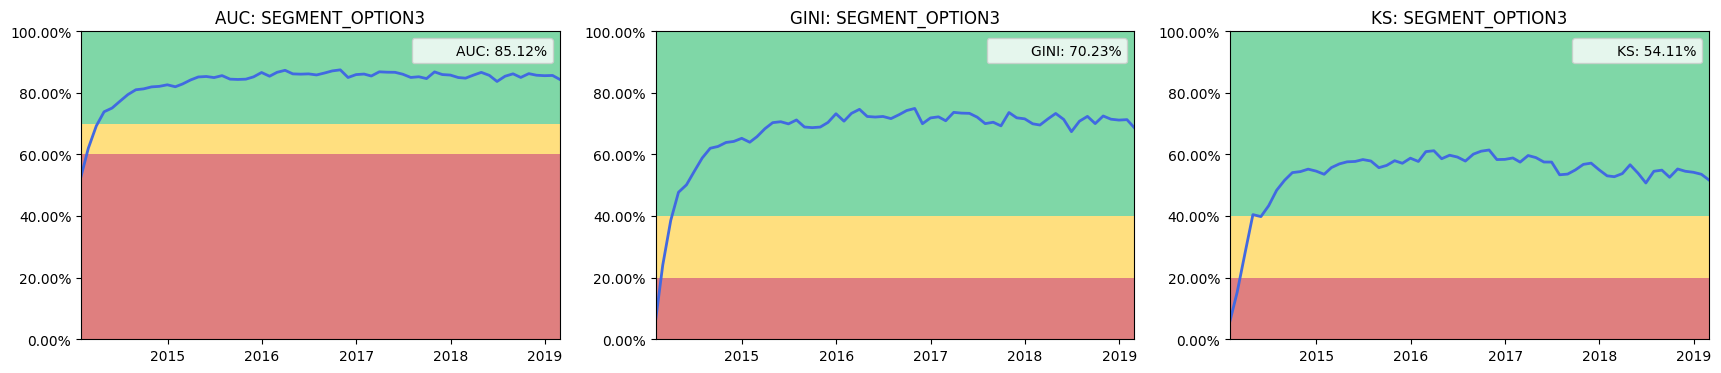

In [52]:
# Option 3: Back-testing
BacktestOption(transaction, 'SEGMENT_OPTION3', output = False)

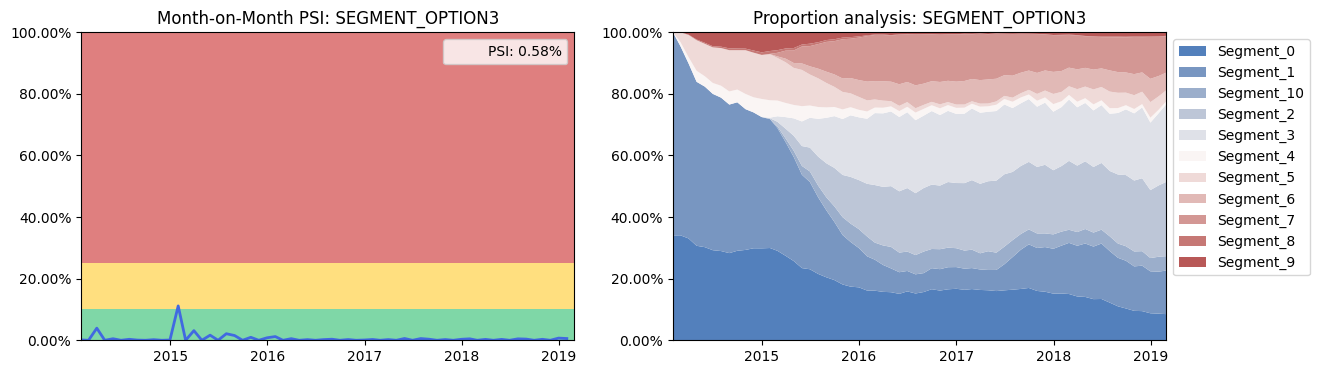

In [53]:
# Option 3: Stable analysis
StableOption(transaction, 'SEGMENT_OPTION3')

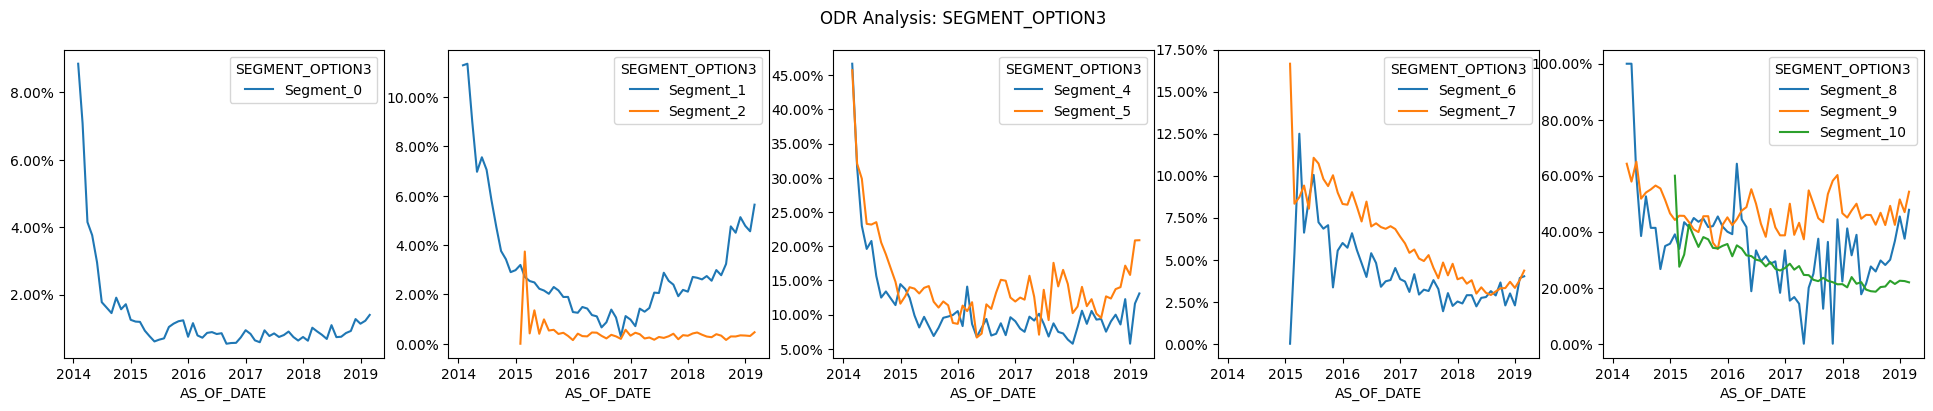

In [54]:
# ODR Analysis
SegmentList = [
    ['Segment_0'],
    ['Segment_1','Segment_2'],
    ['Segment_4','Segment_5'],
    ['Segment_6','Segment_7'],
    ['Segment_8','Segment_9','Segment_10']
]

# Plot
ODRAnalysis(transaction, 'SEGMENT_OPTION3', SegmentList)

In [55]:
# Re-segment --> Option 4: Manual create segments (Result from option 2)
'''
Create ovd 31-60
Create ovd 61-90
'''
def SegmentAssign(ovd, mob, tenor, fin):
  if ovd == 0 and mob <= 12 and tenor <= 60 and fin <= 353000:       return 'Segment_0'
  elif ovd == 0 and mob <= 12 and tenor <= 60 and fin > 353000:      return 'Segment_1'
  elif ovd == 0 and mob <= 12 and tenor > 60:                        return 'Segment_2'
  elif ovd == 0 and mob > 12 and tenor <= 60:                        return 'Segment_3'
  elif ovd == 0 and mob > 12 and tenor > 60:                         return 'Segment_4'
  elif (1 <= ovd <= 30) and mob <= 12:                               return 'Segment_5'
  elif (1 <= ovd <= 30) and mob > 12:                                return 'Segment_6'
  elif (31 <= ovd <= 60):                                            return 'Segment_7'
  elif ovd > 60:                                                     return 'Segment_8'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(SegmentAssign)
segment = func(transaction['OVERDUE_DAYS'], transaction['MOB'], transaction['TOTAL_TERM'], transaction['FINANCED_AMT'])
transaction['SEGMENT_OPTION4'] = segment

In [56]:
# Option 4: Summary
SummaryOption(transaction, 'SEGMENT_OPTION4')

,SEGMENT_OPTION4,N,Bad,ODR,N_pct,Good,cumBad,cumGood,ROC,KS
8,Segment_8,5549,3866,0.696702,0.009382,1683,0.141177,0.002984,0.000211,0.138194
7,Segment_7,32370,8112,0.250602,0.054732,24258,0.437409,0.045991,0.012442,0.391418
5,Segment_5,40459,5195,0.128402,0.068409,35264,0.627118,0.108511,0.033277,0.518607
6,Segment_6,98803,4837,0.048956,0.167058,93966,0.803754,0.275104,0.119187,0.528650
2,Segment_2,101393,3270,0.032251,0.171438,98123,0.923167,0.449068,0.150210,0.474099
1,Segment_1,64555,825,0.012780,0.109151,63730,0.953294,0.562055,0.106008,0.391238
4,Segment_4,107948,714,0.006614,0.182521,107234,0.979368,0.752172,0.183715,0.227196
0,Segment_0,33879,203,0.005992,0.057283,33676,0.986781,0.811876,0.058694,0.174904
3,Segment_3,106472,362,0.003400,0.180025,106110,1.000000,1.000000,0.186880,0.000000


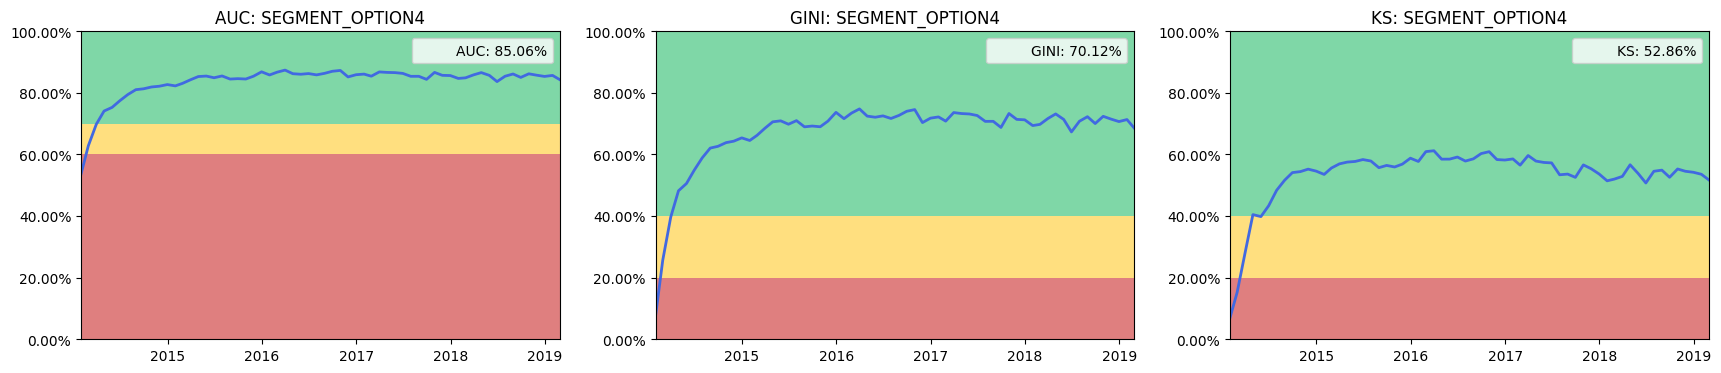

In [57]:
# Option 4: Back-testing
BacktestOption(transaction, 'SEGMENT_OPTION4', output = False)

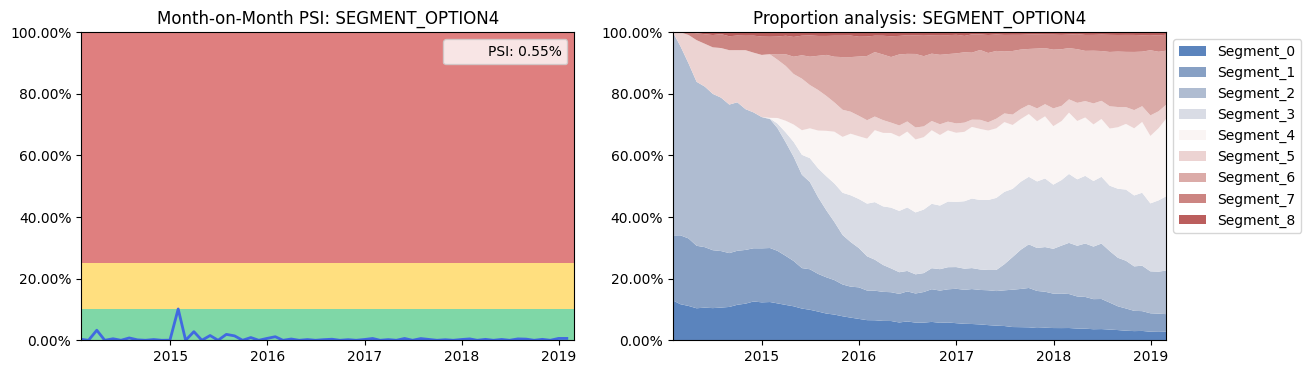

In [58]:
# Option 4: Stable analysis
StableOption(transaction, 'SEGMENT_OPTION4')

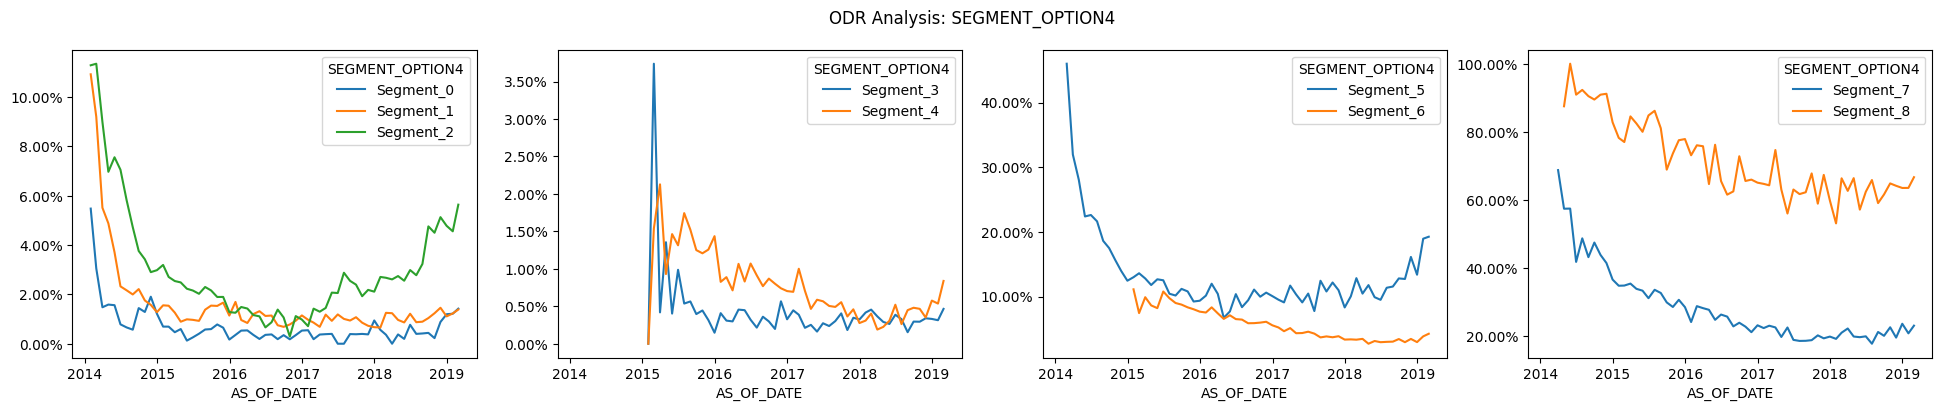

In [59]:
# ODR Analysis
SegmentList = [
    ['Segment_0','Segment_1','Segment_2'],
    ['Segment_3','Segment_4'],
    ['Segment_5','Segment_6'],
    ['Segment_7','Segment_8']
]

# Plot
ODRAnalysis(transaction, 'SEGMENT_OPTION4', SegmentList)

In [60]:
# Re-segment --> Option 5: Manual create segments (Result from option 4)
'''
Create ovd 31-60 and mob <= 12
Create ovd 31-60 and mob > 12
Create ovd 61-90 and mob <= 12
Create ovd 61-90 and mob > 12
'''
def SegmentAssign(ovd, mob, tenor, fin):
  if ovd == 0 and mob <= 12 and tenor <= 60 and fin <= 353000:       return 'Segment_0'
  elif ovd == 0 and mob <= 12 and tenor <= 60 and fin > 353000:      return 'Segment_1'
  elif ovd == 0 and mob <= 12 and tenor > 60:                        return 'Segment_2'
  elif ovd == 0 and mob > 12 and tenor <= 60:                        return 'Segment_3'
  elif ovd == 0 and mob > 12 and tenor > 60:                         return 'Segment_4'
  elif (1 <= ovd <= 30) and mob <= 12:                               return 'Segment_5'
  elif (1 <= ovd <= 30) and mob > 12:                                return 'Segment_6'
  elif (31 <= ovd <= 60) and mob <= 12:                              return 'Segment_7'
  elif (31 <= ovd <= 60) and mob > 12:                               return 'Segment_8'
  elif ovd > 60 and mob <= 12:                                       return 'Segment_9'
  elif ovd > 60 and mob > 12:                                        return 'Segment_10'
  else: return np.nan

# Assign adjusted segmentation
func = np.vectorize(SegmentAssign)
segment = func(transaction['OVERDUE_DAYS'], transaction['MOB'], transaction['TOTAL_TERM'], transaction['FINANCED_AMT'])
transaction['SEGMENT_OPTION5'] = segment

In [61]:
# Option 5: Summary
SummaryOption(transaction, 'SEGMENT_OPTION5')

,SEGMENT_OPTION5,N,Bad,ODR,N_pct,Good,cumBad,cumGood,ROC,KS
10,Segment_9,1832,1517,0.828057,0.003098,315,0.055397,0.000558,0.000015,0.054839
2,Segment_10,3717,2349,0.631961,0.006285,1368,0.141177,0.002984,0.000238,0.138194
8,Segment_7,9083,3457,0.380601,0.015358,5626,0.267419,0.012958,0.002038,0.254461
9,Segment_8,23287,4655,0.199897,0.039374,18632,0.437409,0.045991,0.011641,0.391418
6,Segment_5,40459,5195,0.128402,0.068409,35264,0.627118,0.108511,0.033277,0.518607
7,Segment_6,98803,4837,0.048956,0.167058,93966,0.803754,0.275104,0.119187,0.528650
3,Segment_2,101393,3270,0.032251,0.171438,98123,0.923167,0.449068,0.150210,0.474099
1,Segment_1,64555,825,0.012780,0.109151,63730,0.953294,0.562055,0.106008,0.391238
5,Segment_4,107948,714,0.006614,0.182521,107234,0.979368,0.752172,0.183715,0.227196
0,Segment_0,33879,203,0.005992,0.057283,33676,0.986781,0.811876,0.058694,0.174904


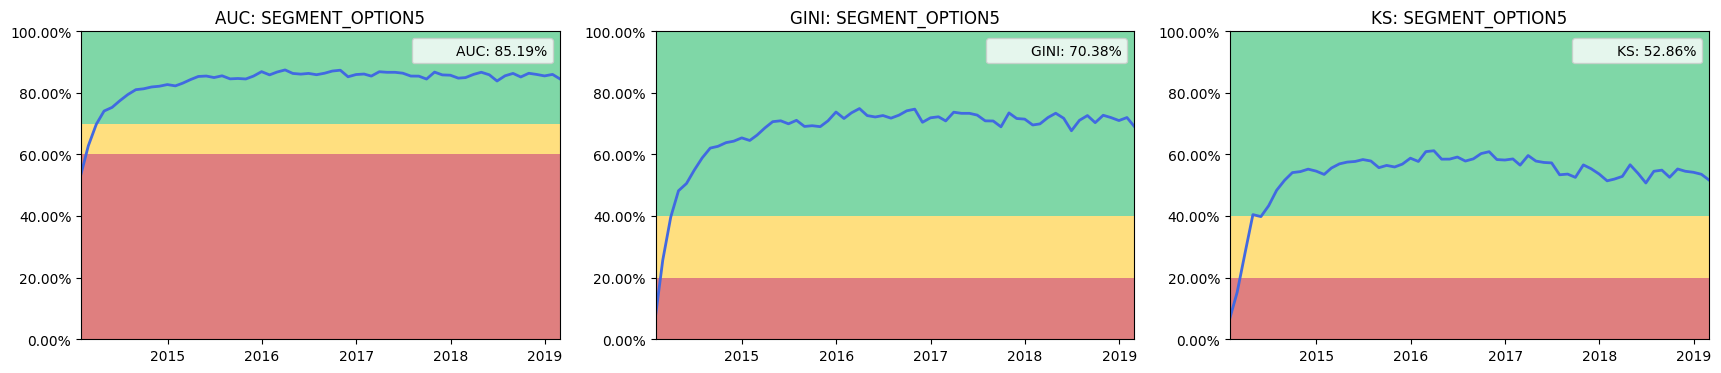

In [62]:
# Option 5: Back-testing
BacktestOption(transaction, 'SEGMENT_OPTION5', output = False)

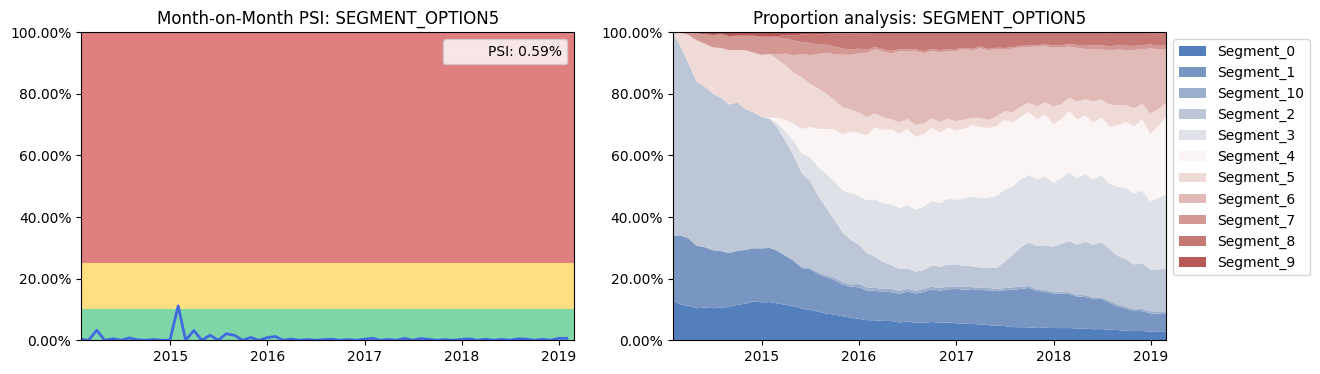

In [63]:
# Option 5: Stable analysis
StableOption(transaction, 'SEGMENT_OPTION5')

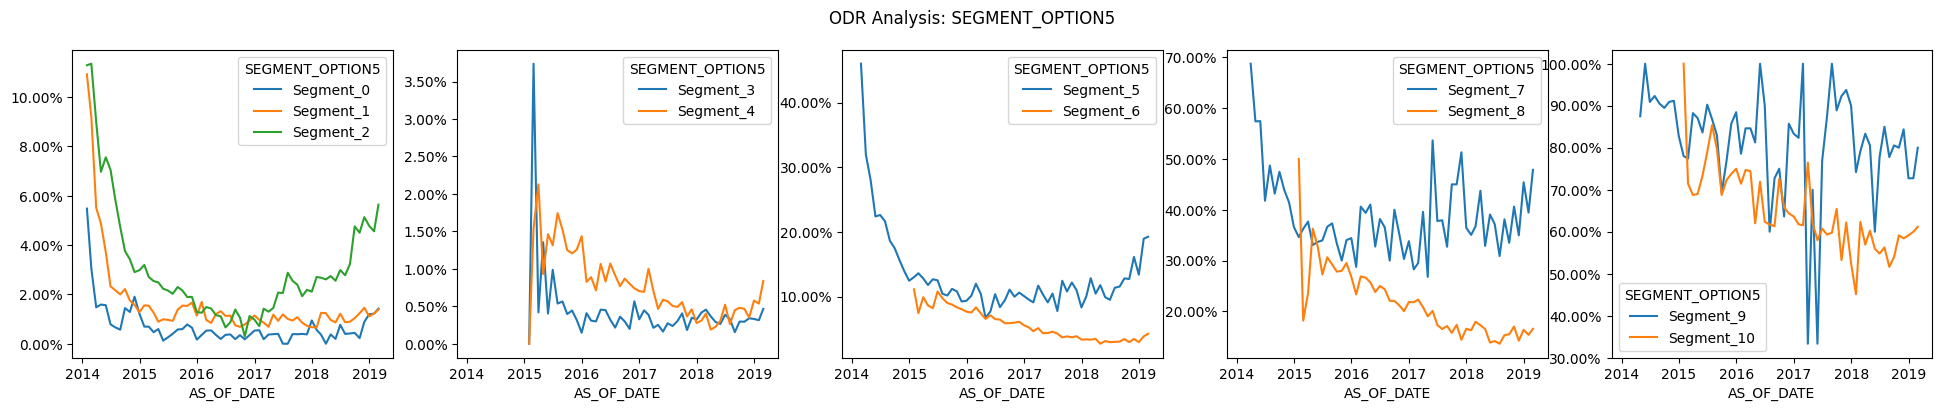

In [64]:
# ODR Analysis
SegmentList = [
    ['Segment_0','Segment_1','Segment_2'],
    ['Segment_3','Segment_4'],
    ['Segment_5','Segment_6'],
    ['Segment_7','Segment_8'],
    ['Segment_9','Segment_10']
]

# Plot
ODRAnalysis(transaction, 'SEGMENT_OPTION5', SegmentList)

In [65]:
# Show result
transaction.head(5)

,APPLICATION_NUMBER,BRANCH,RESTRUCTURE_FLAG,PARTIAL_PAYMENT_FLAG,OUTSTANDING_AMOUNT,CONTRACT_STATUS,TOTAL_TERM,OVERDUE_DAYS,CONTRACT_ID,CUSTOMER_NUMBER,CONTRACT_NUMBER,INSTALLMENT_AMOUNT,DUE_AMOUNT,TOTAL_PAYMENT_MADE,OVERDUE_AMOUNT,FIRST_DUE_DATE,LAST_DUE_DATE,LAST_PAID_DTE,INSTALLMENT_LAST_PAID_DTE,AS_OF_DATE,RESTRUCTURE_DATE,Br_Con,Monthblock,Product_used,Default_flag,Monthkey,FINANCED_AMT,FIRST_PAYMENT_DATE,FIRST_TRANS_MONTH,MOB,BUCKETS,DEFAULT_FLAG,DEFAULT_FLAG1,DEFAULT_FLAG2,DEFAULT_FLAG3,DEFAULT_FLAG4,DEFAULT_FLAG5,DEFAULT_FLAG6,DEFAULT_FLAG7,DEFAULT_FLAG8,DEFAULT_FLAG9,DEFAULT_FLAG10,DEFAULT_FLAG11,DEFAULT_FLAG12,EVER_DEFAULT,YEAR,OVERDUE_DAYS_A,OVERDUE_DAYS_M,TOTAL_TERM_A,TOTAL_TERM_M,FINANCED_AMT_A,FINANCED_AMT_M,YEAR_A,YEAR_M,MOB_6,MOB_12,SEGMENT_OPTION1,SEGMENT_OPTION2,SEGMENT_OPTION3,SEGMENT_OPTION4,SEGMENT_OPTION5
13915,A-A829614,A,N,1,992664.0,10,72.0,0,2416423,5543426,6827745,13787.0,13787.0,0.0,0.0,2014-02-05,2020-01-05,NaT,NaT,2014-01-31,NaT,A6827745,201401,Usedcar,None,1,738020.0,2014-02-06,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2014,"(-inf, 8.00)",0,"[61.00, inf)",Tenor>60,"[516989.00, 777172.00)",FIN_AMT>353000,[2014],Pre-2015,MOB<=6,MOB<=12,Segment_5,Segment_2,Segment_1,Segment_2,Segment_2
13916,A-A829614,A,N,2,978877.0,10,72.0,0,2416423,5543426,6827745,13787.0,13787.0,13787.0,0.0,2014-02-05,2020-01-05,2014-02-06,2014-02-06,2014-02-28,NaT,A6827745,201401,Usedcar,None,2,738020.0,2014-02-06,2.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2014,"(-inf, 8.00)",0,"[61.00, inf)",Tenor>60,"[516989.00, 777172.00)",FIN_AMT>353000,[2014],Pre-2015,MOB<=6,MOB<=12,Segment_5,Segment_2,Segment_1,Segment_2,Segment_2
13917,A-A829614,A,N,1,978877.0,21,72.0,26,2416423,5543426,6827745,13787.0,27574.0,0.0,13787.0,2014-02-05,2020-01-05,2014-02-06,2014-02-06,2014-03-31,NaT,A6827745,201401,Usedcar,None,3,738020.0,2014-02-06,2.0,2.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2014,"[24.00, 30.00)",1-30,"[61.00, inf)",Tenor>60,"[516989.00, 777172.00)",FIN_AMT>353000,[2014],Pre-2015,MOB<=6,MOB<=12,Segment_14,Segment_5,Segment_5,Segment_5,Segment_5
13918,A-A829614,A,N,1,978877.0,41,72.0,56,2416423,5543426,6827745,13787.0,41361.0,0.0,27574.0,2014-02-05,2020-01-05,2014-02-06,2014-02-06,2014-04-30,NaT,A6827745,201401,Usedcar,None,4,738020.0,2014-02-06,2.0,3.0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2014,"[30.00, inf)",30+,"[61.00, inf)",Tenor>60,"[516989.00, 777172.00)",FIN_AMT>353000,[2014],Pre-2015,MOB<=6,MOB<=12,Segment_21,Segment_8,Segment_9,Segment_7,Segment_7
13919,A-A829614,A,N,2,951303.0,41,72.0,26,2416423,5543426,6827745,13787.0,27574.0,27574.0,13787.0,2014-02-05,2020-01-05,2014-05-26,2014-05-26,2014-05-31,NaT,A6827745,201401,Usedcar,None,5,738020.0,2014-02-06,2.0,4.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2014,"[24.00, 30.00)",1-30,"[61.00, inf)",Tenor>60,"[516989.00, 777172.00)",FIN_AMT>353000,[2014],Pre-2015,MOB<=6,MOB<=12,Segment_14,Segment_5,Segment_5,Segment_5,Segment_5


In [66]:
# Export
transaction.to_parquet(
    'SegmentsTransaction.parquet',
    engine = 'pyarrow'
)